In [1]:
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as stats
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import sys

# libraries for partitioning and batching the data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
df = pd.read_csv("default of credit card clients.csv")
data = df.drop('Y', axis=1)
labels = df[['Y']]

In [4]:
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data = torch.tensor(data.values).float()
labels = torch.tensor(labels.values).float()

#X = data
#y = labels

In [5]:
trainsize = 0.75
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=trainsize)
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

In [6]:
batchsize = 8192
# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=batchsize, shuffle=True, drop_last=False)

In [7]:
print(len(train_loader))


3


In [8]:
def createANNmodel():

  # model architecture
  ANN = nn.Sequential(
      nn.Linear(23,64),  # input layer
      nn.ReLU(),        # activation unit
      nn.Linear(64,16),  # hidden layer
      nn.ReLU(),        # activation unit
      nn.Linear(16,1),   # output unit
      nn.Sigmoid(),     # final activation unit
        )

  # loss function
  lossfun = nn.BCELoss() # but better to use BCEWithLogitsLoss

  # optimizer
  optimizer = torch.optim.SGD(ANN.parameters(),lr=0.1)

  # model output
  return ANN,lossfun,optimizer

In [12]:
# Define a global parameter 'numepochs' with a value of 500, representing the number of training epochs.
numepochs = 300

# Define a function 'trainTheModel' to train the neural network.
def trainTheModel(L1lambda):

  # Initialize lists to store training and test accuracies, as well as losses during training.
  trainAcc = []
  testAcc  = []
  losses   = []

#count number of weights in model
  nweights = 0
  for pname, weight in ANN.named_parameters():
    if 'bias' not in pname:
        nweights += weight.numel()

  # Loop over epochs (training iterations).
  for epochi in range(numepochs):
    
    if epochi % 100 == 0:
        print(epochi)
    # Activate training mode for the neural network.
    ANN.train()

    # Initialize lists to store accuracy and loss for each batch during training.
    batchAcc  = []
    batchLoss = []

    # Loop over training data batches.
    for X,y in train_loader:

      # Perform a forward pass through the neural network.
      yHat = ANN(X)
      #print(yHat)
      # Calculate the loss using the specified loss function.
      loss = lossfun(yHat,y)
      # Add L1 regularization term
            # Add L1 regularization term
      with torch.no_grad():
          L1_term = torch.tensor(0., requires_grad=True)
          # Sum up all abs(weights)
          for pname, weight in ANN.named_parameters():
            if 'bias' not in pname:
                L1_term += torch.sum(torch.abs(weight))

      # Add L1 term to the loss
      loss = loss + L1lambda * L1_term / nweights
      
      # Clear previous gradient calculations.
      optimizer.zero_grad()
      
      # Perform backpropagation to compute gradients.
      loss.backward()
      
      # Update the model's parameters using the optimizer.
      optimizer.step()

      # Compute training accuracy for this batch and append to 'batchAcc'.
      #batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchAcc.append( 100*torch.mean(((yHat.round()) == y).float()) )
      
      # Append the loss value for this batch to 'batchLoss'.
      batchLoss.append( loss.item() )
    # End of batch loop...

    # Calculate the average training accuracy for this epoch and append to 'trainAcc'.
    trainAcc.append( np.mean(batchAcc) )

    # Append the average loss for this epoch to 'losses'.
    losses.append( np.mean(batchLoss) )

    # Test accuracy on the validation set.
    
    # Extract X,y from the test dataloader.
    X,y = next(iter(test_loader))

    # Activate evaluation mode (no gradient computation) for the neural network.
    ANN.eval()

    # Perform forward pass for the test data.
    with torch.no_grad():
      #predictions = torch.argmax( ANN(X),axis=1 )
      predictions = ANN(X)
      #print(predictions)
    
    # Compute accuracy on the test data and append to 'testAcc'.
    #testAcc.append( 100*torch.mean((predictions == y).float()).item() )
    testAcc.append( 100*torch.mean(((predictions.round()) == y).float()) )
    #rint(predictions)
    
  
  # Function output: training accuracies, test accuracies, and losses over epochs.
  return trainAcc, testAcc, losses

In [13]:
# create a 1D smoothing filter

# Define a Python function called smooth that performs 1D smoothing on a given array of values.
# The function takes two arguments:
# - x: The input array to be smoothed.
# - k: An integer specifying the smoothing window size.

def smooth(x, k):
    # Use NumPy's convolve function to perform the smoothing.
    # np.ones(k) creates a 1D kernel of size k, where all elements are set to 1.
    # np.ones(k) / k normalizes the kernel by dividing each element by k.
    # This creates a kernel that will compute the weighted moving average of the input data.
    # The mode='same' argument ensures that the output has the same shape as the input.
    return np.convolve(x, np.ones(k) / k, mode='same')

# In summary, this smooth function takes an input array x and applies a weighted moving average
# smoothing operation with a specified window size k. The result is a smoothed array.

In [14]:
# Define a range of L1 regularization amounts (L1lambda) using NumPy's linspace function.
# This creates an array of 10 evenly spaced values ranging from 0 to 0.01.
L1lambda = np.linspace(0, 0.01, 10)

# Initialize empty matrices to store training and testing accuracy results.
# These matrices will have dimensions (numepochs, len(L1lambda)).
# numepochs is a global parameter representing the number of training epochs.
accuracyResultsTrain = np.zeros((numepochs, len(L1lambda)))
accuracyResultsTest = np.zeros((numepochs, len(L1lambda)))

# Loop over different L1 regularization values.
for li in range(len(L1lambda)):
    print(li)
    # Create a new ANN model, specify the loss function, and optimizer.
    ANN, lossfun, optimizer = createANNmodel()

    # Train the model with the current L1 regularization value (L1lambda[li]).
    trainAcc, testAcc, losses = trainTheModel(L1lambda[li])

    # Smooth the training and testing accuracy curves using a smoothing window of 10.
    # This helps reduce noise in the accuracy curves, making them easier to interpret.
    accuracyResultsTrain[:, li] = smooth(trainAcc, 10)
    accuracyResultsTest[:, li] = smooth(testAcc, 10)

0
0
100
200
1
0
100
200
2
0
100
200
3
0
100
200
4
0
100
200
5
0
100
200
6
0
100
200
7
0
100
200
8
0
100
200
9
0
100
200


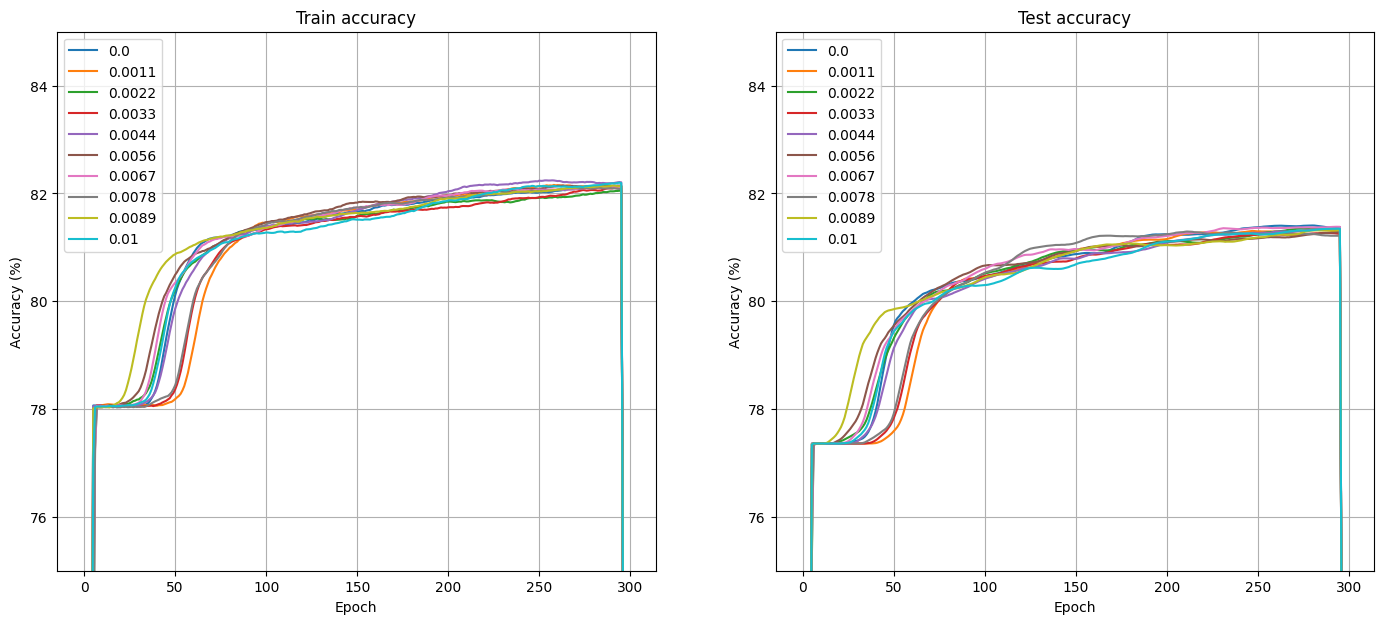

In [18]:
# Create a figure with two subplots (1 row, 2 columns) and set the overall size to (17,7).
fig, ax = plt.subplots(1, 2, figsize=(17, 7))

# Plot the training accuracy results in the first subplot (ax[0]).
ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')  # Set the title of the subplot to 'Train accuracy'.

# Plot the testing accuracy results in the second subplot (ax[1]).
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')  # Set the title of the subplot to 'Test accuracy'.

# Create a list of labels for the legend based on the L1 regularization values (L1lambda).
# These labels are rounded to four decimal places for readability.
leglabels = [np.round(i, 4) for i in L1lambda]

# Loop over the two subplots (ax[0] and ax[1]) for common formatting.
for i in range(2):
    ax[i].legend(leglabels)  # Add the legend with the L1 regularization values.
    ax[i].set_xlabel('Epoch')  # Set the x-axis label to 'Epoch'.
    ax[i].set_ylabel('Accuracy (%)')  # Set the y-axis label to 'Accuracy (%)'.
    ax[i].set_ylim([75, 85])  # Set the y-axis limits for accuracy values between 50% and 101%.
    ax[i].grid()  # Add gridlines to the subplot.

# Display the plot with both training and testing accuracy curves.
plt.show()

In [16]:
from torchsummary import summary
summary(ANN, (1,23))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           1,536
              ReLU-2                [-1, 1, 64]               0
            Linear-3                [-1, 1, 16]           1,040
              ReLU-4                [-1, 1, 16]               0
            Linear-5                 [-1, 1, 1]              17
           Sigmoid-6                 [-1, 1, 1]               0
Total params: 2,593
Trainable params: 2,593
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------
